In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from main import *
from multiprocessing import Pool
import pandas as pd

In [29]:
models = [
    TwoOsillators(strengthLambda=4, distanceD0=0.25, omega1=3, omega2=-3, couplesNum=2, savePath="./data", overWrite=True, tqdm=True),
    TwoOsillators(strengthLambda=4, distanceD0=0.5, omega1=3, omega2=-3, couplesNum=2, savePath="./data", overWrite=True, tqdm=True),
    TwoOsillators(strengthLambda=4, distanceD0=0.75, omega1=2.75, omega2=-3, couplesNum=2, savePath="./data", overWrite=True, tqdm=True),
    TwoOsillators(strengthLambda=4, distanceD0=1, omega1=2.5, omega2=-3, couplesNum=2, savePath="./data", overWrite=True, tqdm=True),
    TwoOsillators(strengthLambda=4, distanceD0=0.5, omega1=2, omega2=3, couplesNum=2, savePath="./data", overWrite=True, tqdm=True),
    TwoOsillators(strengthLambda=4, distanceD0=0.75, omega1=2, omega2=3, couplesNum=2, savePath="./data", overWrite=True, tqdm=True),
    TwoOsillators(strengthLambda=4, distanceD0=0.5, omega1=2.25, omega2=3, couplesNum=2, savePath="./data", overWrite=True, tqdm=True),
    TwoOsillators(strengthLambda=4, distanceD0=0.25, omega1=2.5, omega2=3, couplesNum=2, savePath="./data", overWrite=True, tqdm=True),
]
for model in models[-1:]:
    model.run(5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

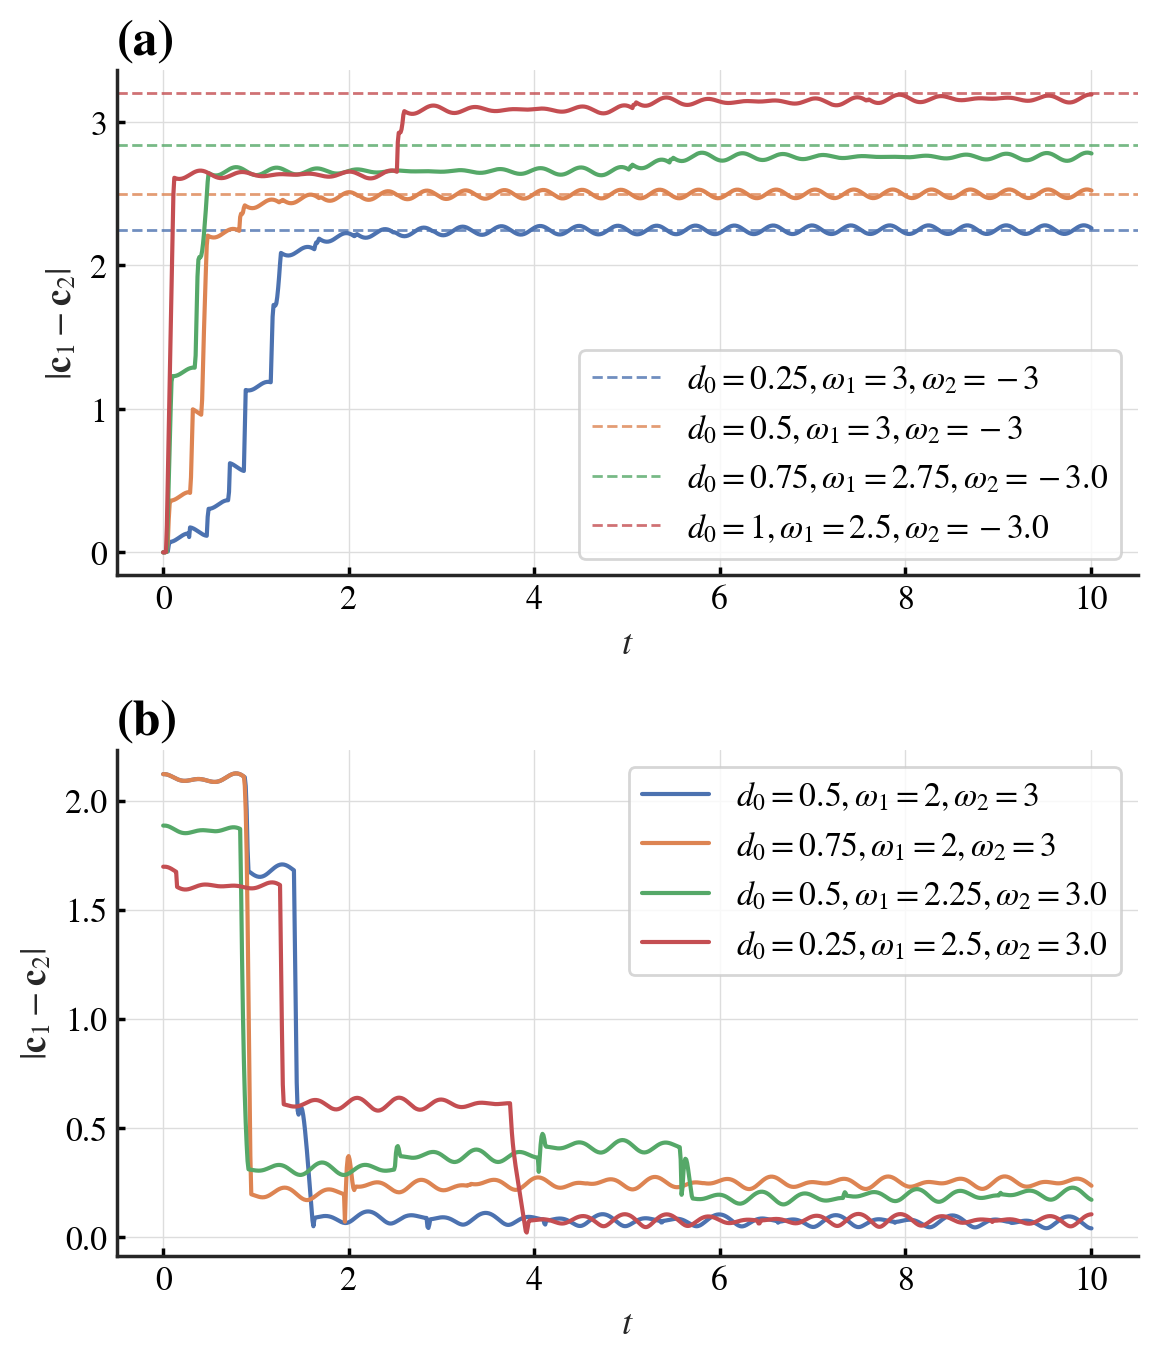

In [30]:
def get_ts_centers_no_mod(model: TwoOsillators):
    sa = StateAnalysis(model, classDistance=0.3, lookIndex=0)
    ts_centers = []
    for i in range(1, sa.totalPhaseTheta.shape[0]):
        positionx = sa.totalPositionX[i, :, 0]
        positiony = sa.totalPositionX[i, :, 1]
        omegaTheta = model.omegaTheta
        center = np.array([
            positionx - 3 / omegaTheta * np.sin(sa.totalPhaseTheta[i, :]),
            positiony + 3 / omegaTheta * np.cos(sa.totalPhaseTheta[i, :])
        ]).T
        ts_centers.append(center)
    ts_centers.insert(0, ts_centers[0])
    return np.array(ts_centers)

fig, axs = plt.subplots(2, 1, figsize=(6, 7))
ax1, ax2 = axs
colorIdx = 0

for model in models[:4]:
    targetPath = f"./data/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    tsCentersNoMod = get_ts_centers_no_mod(model)
    sub = tsCentersNoMod[:, 0] - tsCentersNoMod[:, 1]
    distance = np.sqrt(np.sum(sub ** 2, axis=1))
    ax1.plot(np.arange(len(distance)) * 0.01, distance, color=f"C{colorIdx}")
    omega1, omega2 = model.omegaTheta
    ax1.axline((0, model.distanceD0 + np.sum(3 / np.abs(model.omegaTheta))), slope=0, 
               color=f"C{colorIdx}", linestyle="--", alpha=0.8, lw=1,
               label=fr"$d_0={model.distanceD0}, \omega_1={omega1}, \omega_2={omega2}$")
    colorIdx += 1

ax1.legend()
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"$\left| \mathbf{c}_1-\mathbf{c}_2 \right|$")
ax1.tick_params(direction='in', length=3)
ax1.grid(True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title("(a)", loc="left", fontweight='bold', fontsize=18)

colorIdx = 0
for model in models[4:]:
    targetPath = f"./data/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    tsCentersNoMod = get_ts_centers_no_mod(model)
    sub = tsCentersNoMod[:, 0] - tsCentersNoMod[:, 1]
    distance = np.sqrt(np.sum(sub ** 2, axis=1))
    omega1, omega2 = model.omegaTheta
    ax2.plot(np.arange(len(distance)) * 0.01, distance, color=f"C{colorIdx}",
             label=fr"$d_0={model.distanceD0}, \omega_1={omega1}, \omega_2={omega2}$")
    colorIdx += 1

ax2.legend()
ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"$\left| \mathbf{c}_1-\mathbf{c}_2 \right|$")
ax2.tick_params(direction='in', length=3)
ax2.grid(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_title("(b)", loc="left", fontweight='bold', fontsize=18)

plt.tight_layout()
plt.savefig("./PJT_C_Fig/2OsCenterDistance.pdf", bbox_inches="tight")

(0.0, 10.0)

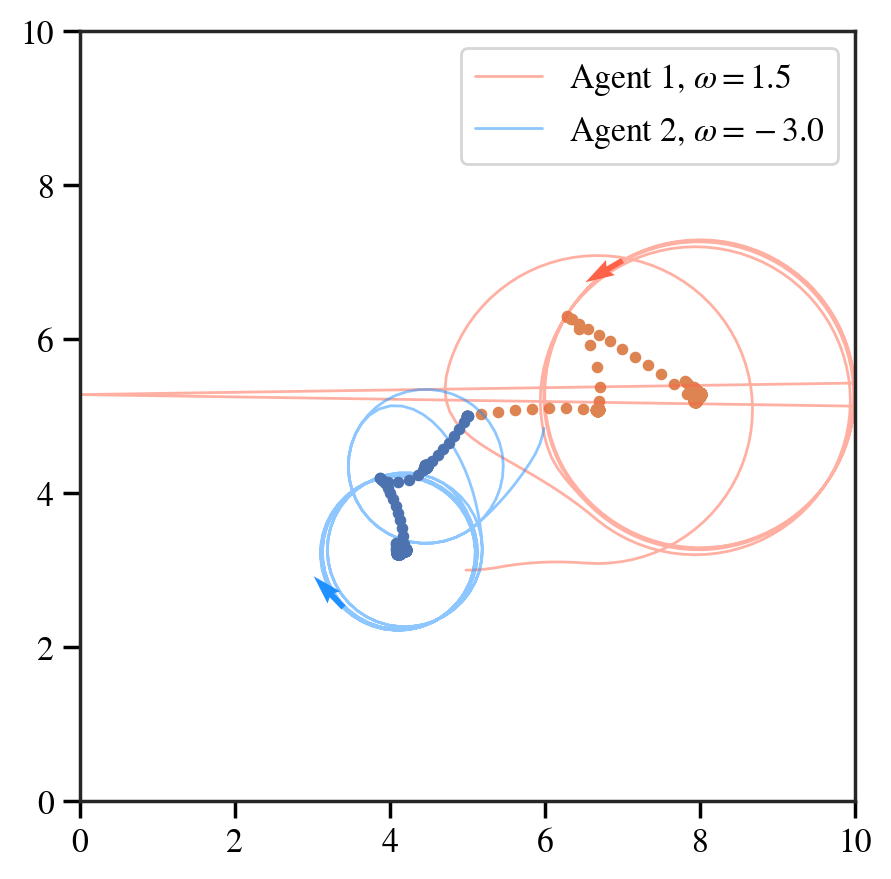

In [8]:
targetPath = f"./data/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
TNum = totalPositionX.shape[0] // model.agentsNum
totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
fig, ax = plt.subplots(figsize=(5, 5))
trajectoryLength = 0
plt.plot(totalPositionX[-trajectoryLength:, 0, 0], totalPositionX[-trajectoryLength:, 0, 1], color="tomato", alpha=0.5, lw=1)
plt.plot(totalPositionX[-trajectoryLength:, 1, 0], totalPositionX[-trajectoryLength:, 1, 1], color='dodgerblue', alpha=0.5, lw=1)
plt.quiver(
    totalPositionX[-1, 0, 0], totalPositionX[-1, 0, 1],
    np.cos(totalPhaseTheta[-1, 0]), np.sin(totalPhaseTheta[-1, 0]), color="tomato", zorder=10
)
plt.quiver(
    totalPositionX[-1, 1, 0], totalPositionX[-1, 1, 1],
    np.cos(totalPhaseTheta[-1, 1]), np.sin(totalPhaseTheta[-1, 1]), color="dodgerblue", zorder=10
)
plt.scatter(
    totalPositionX[:, 1, 0] - 3 / model.omegaTheta[1] * np.sin(totalPhaseTheta[:, 1]),
    totalPositionX[:, 1, 1] + 3 / model.omegaTheta[1] * np.cos(totalPhaseTheta[:, 1]), s=10, zorder=10
)
plt.scatter(
    totalPositionX[:, 0, 0] - 3 / model.omegaTheta[0] * np.sin(totalPhaseTheta[:, 0]),
    totalPositionX[:, 0, 1] + 3 / model.omegaTheta[0] * np.cos(totalPhaseTheta[:, 0]), s=10
)
plt.legend([fr"Agent 1, $\omega={model.omegaTheta[0]}$", fr"Agent 2, $\omega={model.omegaTheta[1]}$"])

plt.xlim(0, 10)
plt.ylim(0, 10)

(0.0, 10.0)

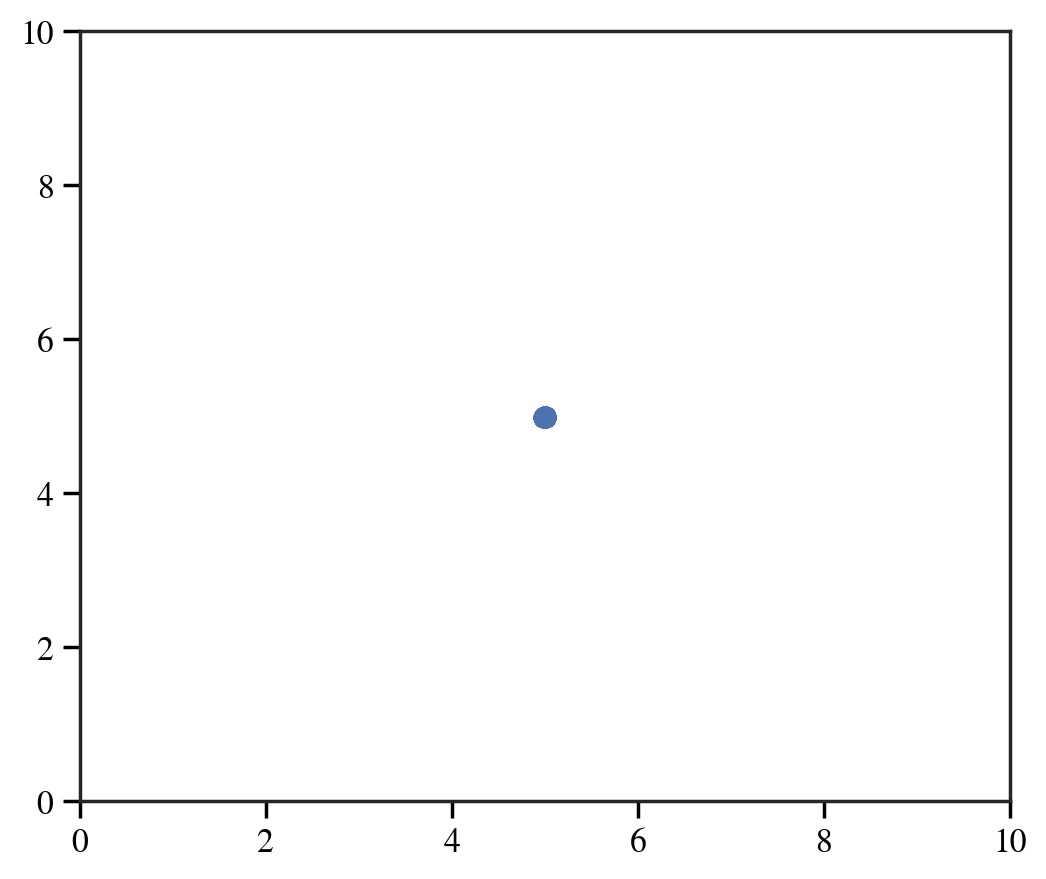

In [7]:
plt.scatter(
    totalPositionX[:, 1, 0] - 3 / model.omegaTheta[1] * np.sin(totalPhaseTheta[:, 1]),
    totalPositionX[:, 1, 1] + 3 / model.omegaTheta[1] * np.cos(totalPhaseTheta[:, 1])
)
plt.xlim(0, 10)
plt.ylim(0, 10)

(0.0, 10.0)

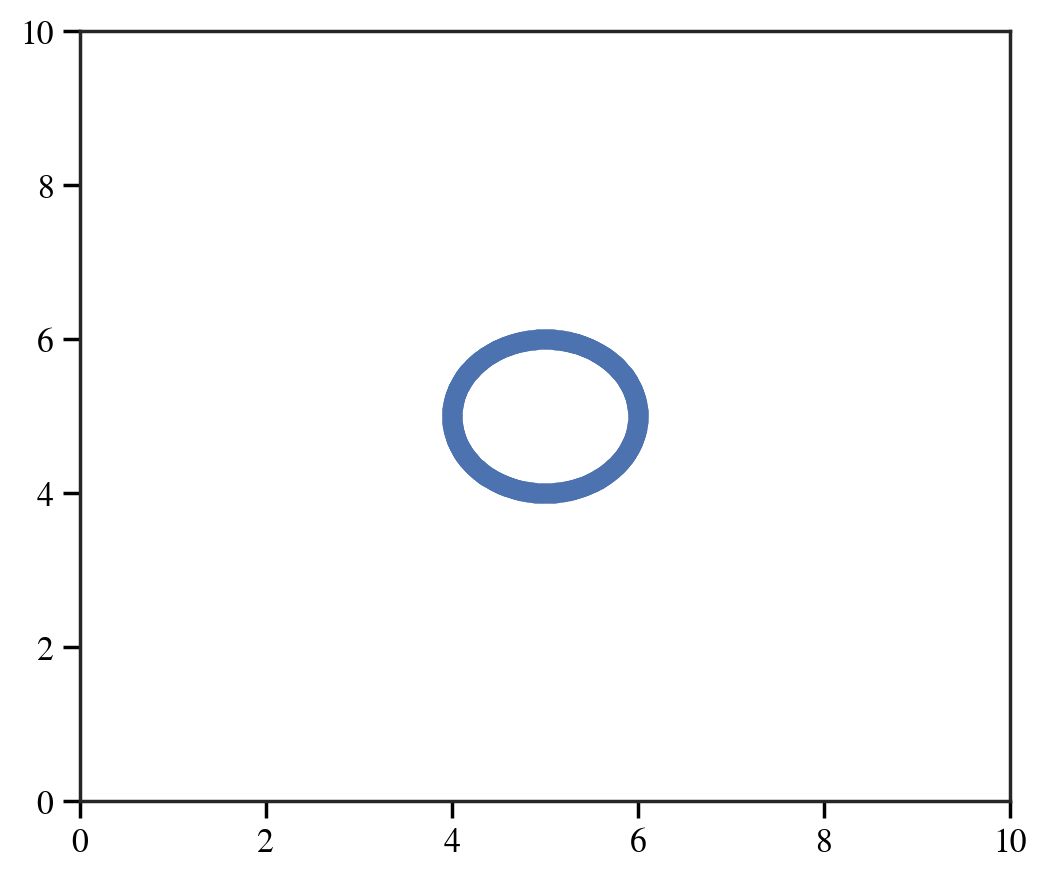

In [6]:
t = np.linspace(0, 10, 1000)
theta0 = np.pi / 2
omega = 3
v = 3
plt.scatter(5 + v / omega * np.sin(theta0 + omega * t), 
            5 - v / omega * np.cos(theta0 + omega * t))
plt.xlim(0, 10)
plt.ylim(0, 10)

In [185]:
from sympy import symbols, Eq, Function, dsolve, cos, sin

t, v, omega = symbols('t v omega')
x = symbols('x', cls=Function)(t)
y = symbols('y', cls=Function)(t)

eq1 = Eq(x.diff(t), v * cos(omega * t))
eq2 = Eq(y.diff(t), v * sin(omega * t))

solutions = dsolve([eq1, eq2])

for solution in solutions:
    display(solution)

Eq(x(t), C1 + v*Piecewise((sin(omega*t)/omega, Ne(omega, 0)), (t, True)))

Eq(y(t), C2 + v*Piecewise((-cos(omega*t)/omega, Ne(omega, 0)), (0, True)))

In [124]:
model = TwoOsillators(strengthLambda=3, distanceD0=0.5, omega1=3, omega2=-3,
                      couplesNum=1, savePath="./data", overWrite=True)
model.run(1030)

targetPath = f"./data/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
TNum = totalPositionX.shape[0] // model.agentsNum
totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)

(0.0, 10.0)

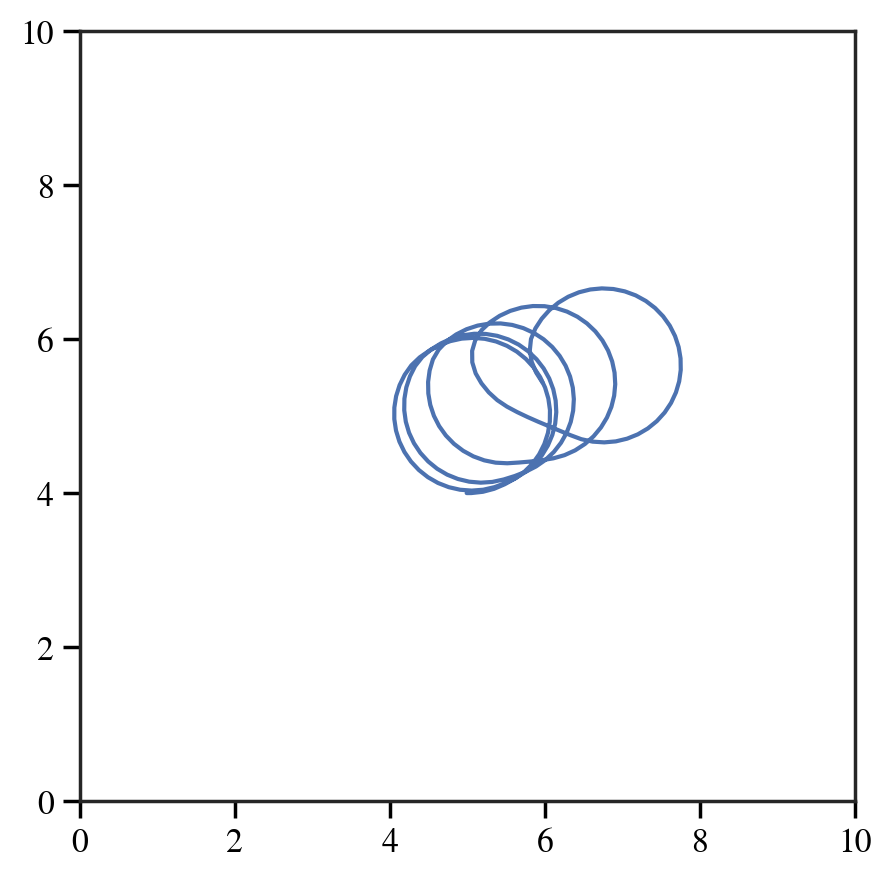

In [125]:
plt.figure(figsize=(5, 5))
plt.plot(totalPositionX[:, 0, 0], totalPositionX[:, 0, 1])# - 5
plt.xlim(0, 10)
plt.ylim(0, 10)

In [126]:
position = totalPositionX[:, 0] - 5
phaseTheta = totalPhaseTheta[:, 0]
spatialAngle = np.arctan2(position[:, 1], position[:, 0])

In [27]:
from sympy import symbols, Function, Eq, dsolve, sin, cos, sqrt

xi, xj, yi, yj, v, omegai, omegaj, thetai, thetaj = symbols('x_i x_j y_i y_j v omega_i omega_j theta_i theta_j')
cicj = sqrt(
    (xj - v / omegaj * sin(thetaj) - xi + v / omegai * sin(thetai))**2 +
    (yj + v / omegaj * cos(thetaj) - yi - v / omegai * cos(thetai))**2
)
# 展开cicj
cicj = cicj.simplify().expand()

In [30]:
# 转化为latex
from sympy import latex
print(latex(cicj))

\sqrt{x_{i}^{2} - 2 x_{i} x_{j} + x_{j}^{2} + y_{i}^{2} - 2 y_{i} y_{j} + y_{j}^{2} + \frac{2 v x_{i} \sin{\left(\theta_{j} \right)}}{\omega_{j}} - \frac{2 v x_{j} \sin{\left(\theta_{j} \right)}}{\omega_{j}} - \frac{2 v y_{i} \cos{\left(\theta_{j} \right)}}{\omega_{j}} + \frac{2 v y_{j} \cos{\left(\theta_{j} \right)}}{\omega_{j}} + \frac{v^{2} \sin^{2}{\left(\theta_{j} \right)}}{\omega_{j}^{2}} + \frac{v^{2} \cos^{2}{\left(\theta_{j} \right)}}{\omega_{j}^{2}} - \frac{2 v x_{i} \sin{\left(\theta_{i} \right)}}{\omega_{i}} + \frac{2 v x_{j} \sin{\left(\theta_{i} \right)}}{\omega_{i}} + \frac{2 v y_{i} \cos{\left(\theta_{i} \right)}}{\omega_{i}} - \frac{2 v y_{j} \cos{\left(\theta_{i} \right)}}{\omega_{i}} - \frac{2 v^{2} \sin{\left(\theta_{i} \right)} \sin{\left(\theta_{j} \right)}}{\omega_{i} \omega_{j}} - \frac{2 v^{2} \cos{\left(\theta_{i} \right)} \cos{\left(\theta_{j} \right)}}{\omega_{i} \omega_{j}} + \frac{v^{2} \sin^{2}{\left(\theta_{i} \right)}}{\omega_{i}^{2}} + \frac{v^{2} \cos

In [38]:
"\t"

'\t'

In [41]:
eq = r"""
    \sqrt{\left( x_i-x_j \right) ^2+\left( y_i-y_j \right) ^2-\frac{2v^2\sin \theta _i\sin \theta _j}{\omega _i\omega _j}-\frac{2v^2\cos \theta _i\cos \theta _j}{\omega _i\omega _j}+2\frac{v^2}{\omega _{i}^{2}}+\frac{2v\left[ \left( x_i-x_j \right) \sin \theta _j-\left( y_i-y_j \right) \cos \theta _j \right]}{\omega _j}-\frac{2v\left[ \left( x_i-x_j \right) \sin \theta _i-\left( y_i-y_j \right) \cos \theta _i \right]}{\omega _i}}
    """
# 把eq转化为sympy表达式
from sympy import sympify
cicj = sympify(eq)

SympifyError: Sympify of expression 'could not parse '    \\sqrt{\\left( x_i-x_j \\right) ^2+\\left( y_i-y_j \\right) ^2-\\frac{2v^2\\sin \\theta _i\\sin \\theta _j}{\\omega _i\\omega _j}-\\frac{2v^2\\cos \\theta _i\\cos \\theta _j}{\\omega _i\\omega _j}+2\\frac{v^2}{\\omega _{i}^{2}}+\\frac{2v\\left[ \\left( x_i-x_j \\right) \\sin \\theta _j-\\left( y_i-y_j \\right) \\cos \\theta _j \\right]}{\\omega _j}-\\frac{2v\\left[ \\left( x_i-x_j \\right) \\sin \\theta _i-\\left( y_i-y_j \\right) \\cos \\theta _i \\right]}{\\omega _i}}    '' failed, because of exception being raised:
SyntaxError: unexpected character after line continuation character (<string>, line 1)